## Yahoo Fundamental

## STOCKS



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib
import math
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup
import requests
from django.core.validators import RegexValidator
from django.http import JsonResponse, Http404
import pandas as pd
import matplotlib.pyplot as plt


In [2]:

# S&P 500 → ^GSPC
# Dow Jones → ^DJI
# Nasdaq 100 → ^NDX
# Russell 2000 → ^RUT
# DAX (Alemanha) → ^GDAXI
# Definir o ticker da ação
symbol = "AAPL"  # Apple Inc.
# symbol = "^GSPC"  # Apple Inc.
# symbol = "XLK"  # Apple Inc.

# Definir período e intervalo
period = "1y"       # Período de 1 mês
interval = "1d"      # Dados diários

In [3]:
yahoo_symbol_info = yf.Ticker(symbol).info
yahoo_symbol_balancesheet = yf.Ticker(symbol).balance_sheet
yahoo_symbol_balancesheet_quarter = yf.Ticker(symbol).quarterly_balance_sheet
yahoo_symbol_income = yf.Ticker(symbol).income_stmt
yahoo_symbol_income_quarter = yf.Ticker(symbol).quarterly_income_stmt
yahoo_symbol_cashflow = yf.Ticker(symbol).cash_flow
yahoo_symbol_cashflow_quarter = yf.Ticker(symbol).quarterly_cash_flow

In [ ]:
# ROA
# Total Assets Year
if 'Total Assets' in yahoo_symbol_balancesheet.index:
    assets_fy = yahoo_symbol_balancesheet.loc['Total Assets']
    if pd.isna(assets_fy).all():
        assets_fy = None
        assets_fy_mean = None
    else:
        assets_fy = assets_fy.dropna()
        assets_fy_mean = (assets_fy.shift(1) + assets_fy) / 2
else:
    assets_fy = None
    assets_fy_mean = None

# Total Assets Quarter
if 'Total Assets' in yahoo_symbol_balancesheet_quarter.index:
    assets_quarter = yahoo_symbol_balancesheet_quarter.loc['Total Assets']
    if pd.isna(assets_quarter).all():
        assets_quarter = None
        assets_quarter_mean = None
    else:
        assets_quarter = assets_quarter.dropna()
        assets_quarter_mean = (assets_quarter.shift(1) + assets_quarter) / 2
else:
    assets_quarter = None
    assets_quarter_mean = None

# net_income_fy Year
if 'Net Income' in yahoo_symbol_income.index:
    net_income_fy = yahoo_symbol_income.loc['Net Income']
    if pd.isna(net_income_fy).all():
        net_income_fy = None
    else:
        net_income_fy = net_income_fy.dropna()
else:
    net_income_fy = None

# net_income Quarter
if 'Net Income' in yahoo_symbol_income_quarter.index:
    net_income_quarter = yahoo_symbol_income_quarter.loc['Net Income']
    if pd.isna(net_income_quarter).all():
        net_income_quarter = None
    else:
        net_income_quarter = net_income_quarter.dropna()
else:
    net_income_quarter = None


roa = net_income_ttm / last_assets_mean \
    if net_income_ttm is not None \
    and last_assets_mean not in (None, 0) \
    else None

roa

2024-09-30         NaN
2023-09-30    1.628854
2022-09-30    1.769274
2021-09-30    1.664528
dtype: float64

In [11]:
# - Market Cap
market_cap = yahoo_symbol_info.get('marketCap')
if market_cap is None or (isinstance(market_cap, float) and math.isnan(market_cap)):
    market_cap = None

# - Total Debt
if 'Total Debt' in yahoo_symbol_balancesheet.index:
    total_debt = yahoo_symbol_balancesheet.loc["Total Debt"]
    if pd.isna(total_debt).all():
        total_debt = None
        total_debt_last = None
    else:
        total_debt = total_debt.dropna()
        total_debt_last = total_debt.iloc[0]
else:
    total_ebitda = None
    total_debt_last = None

# - Minority Interest
if 'Total Equity Gross Minority Interest' in yahoo_symbol_balancesheet.index:
    total_equity_gross_minority_interest = yahoo_symbol_balancesheet.loc["Total Equity Gross Minority Interest"]
    if pd.isna(total_equity_gross_minority_interest).all():
        total_equity_gross_minority_interest = None
        total_equity_gross_minority_interest_last = None
    else:
        total_equity_gross_minority_interest = total_equity_gross_minority_interest.dropna()
        total_equity_gross_minority_interest_last = total_equity_gross_minority_interest.iloc[0]
else:
    total_equity_gross_minority_interest = None
    total_equity_gross_minority_interest_last = None

# - Stockholders Equity
if 'Stockholders Equity' in yahoo_symbol_balancesheet.index:
    stockholders_equity = yahoo_symbol_balancesheet.loc["Stockholders Equity"]
    if pd.isna(stockholders_equity).all():
        stockholders_equity = None
        stockholders_equity_last = None
        stockholders_equity_mean = None
        last_stockholders_equity_mean = None
    else:
        stockholders_equity = stockholders_equity.dropna()
        stockholders_equity_last = stockholders_equity.iloc[0]
        stockholders_equity_mean = (stockholders_equity.shift(1) + stockholders_equity) / 2
        last_stockholders_equity_mean = stockholders_equity_mean.dropna().iloc[0]
else:
    stockholders_equity = None
    stockholders_equity_last = None
    stockholders_equity_mean = None
    last_stockholders_equity_mean = None

minority_interest = total_equity_gross_minority_interest_last - stockholders_equity_last \
    if stockholders_equity_last is not None \
    and total_equity_gross_minority_interest_last is not None \
    else None

preferred_equity = 0

# - Debt & cash (preferidos)
if 'Cash Cash Equivalents And Short Term Investments' in yahoo_symbol_balancesheet.index:
    cash_sti = yahoo_symbol_balancesheet.loc["Cash Cash Equivalents And Short Term Investments"]
    if pd.isna(cash_sti).all():
        cash_sti = None
        cash_sti_last = None
    else:
        cash_sti = cash_sti.dropna()
        cash_sti_last = cash_sti.iloc[0]
else:
    cash_sti = None
    cash_sti_last = None

if cash_sti_last is None:
    if 'Cash And Cash Equivalents' in yahoo_symbol_balancesheet.index:
        cash = yahoo_symbol_balancesheet.loc["Cash And Cash Equivalents"]
        if pd.isna(cash).all():
            cash = None
            cash_last = None
        else:
            cash = cash.dropna()
            cash_last = cash.iloc[0]
    else:
        cash = None
        cash_last = None

    if 'Other Short Term Investments' in yahoo_symbol_balancesheet.index:
        sti = yahoo_symbol_balancesheet.loc["Other Short Term Investments"]
        if pd.isna(cash).all():
            sti = None
            sti_last = None
        else:
            sti = sti.dropna()
            sti_last = sti.iloc[0]
    else:
        sti = None
        sti_last = None

    cash_sti_last = (cash_last or 0) + (sti_last or 0) \
        if cash_last is not None \
        and sti_last is not None \
        else None

enterprise_value = market_cap + total_debt_last + minority_interest + preferred_equity - cash_sti_last \
    if market_cap is not None \
    and total_debt_last is not None \
    and minority_interest is not None \
    and preferred_equity is not None \
    and cash_sti_last is not None \
    else None


# - Net Debt / EBITDA
net_debt = total_debt_last - cash_sti_last \
    if cash_sti_last is not None \
    and total_debt_last is not None \
    else None

# - Total Revenue ---- ADICIONAR ISTO em todo o lado e criar função generica
if 'EBITDA' in yahoo_symbol_income_quarter.index:
    total_ebitda = yahoo_symbol_income_quarter.loc['EBITDA']
    if pd.isna(total_ebitda).all():
        total_ebitda = None
        ebitda_ttm = None
    else:
        total_ebitda = total_ebitda.dropna()
        ebitda_ttm = total_ebitda.sum()
else:
    total_ebitda = None
    ebitda_ttm = None

net_debt_ebitda = net_debt / ebitda_ttm \
    if net_debt is not None \
    and ebitda_ttm is not None \
    and ebitda_ttm > 0 \
    else None

# - Interest Coverage (EBIT)
if 'EBIT' in yahoo_symbol_income_quarter.index:
    ebit_quarter = yahoo_symbol_income_quarter.loc['EBIT']
    if pd.isna(ebit_quarter).all():
        ebit_quarter = None
        ebit_quarter_ttm = None
    else:
        ebit_quarter = ebit_quarter.dropna()
        ebit_quarter_ttm = ebit_quarter.sum()
else:
    ebit_quarter = None
    ebit_quarter_ttm = None

# - Interest Expense
if 'Interest Expense' in yahoo_symbol_income.index:
    interest_expense = yahoo_symbol_income.loc['Interest Expense']
    if pd.isna(interest_expense).all():
        interest_expense = None
        interest_expense_ttm = None
        interest_expense_last = None
    else:
        interest_expense = interest_expense.dropna()
        interest_expense_ttm = interest_expense.sum()
        interest_expense_last = interest_expense.iloc[0]
else:
    interest_expense = None
    interest_expense_ttm = None
    interest_expense_last = None

interest_coverage_ebit = ebit_quarter_ttm / abs(interest_expense_ttm) \
    if ebit_quarter_ttm is not None \
    and interest_expense_ttm not in (None, 0) \
    else None

# - Current Racio
# current_assets
if 'Current Assets' in yahoo_symbol_balancesheet_quarter.index:
    current_assets_quarter = yahoo_symbol_balancesheet_quarter.loc['Current Assets']
    if pd.isna(current_assets_quarter).all():
        current_assets_quarter = None
        current_assets_quarter_last = None
    else:
        current_assets_quarter = current_assets_quarter.dropna()
        current_assets_quarter_last = current_assets_quarter.iloc[0]
else:
    current_assets_quarter = None
    current_assets_quarter_last = None

# current_liabilities
if 'Current Liabilities' in yahoo_symbol_balancesheet_quarter.index:
    current_liabilities_quarter = yahoo_symbol_balancesheet_quarter.loc['Current Liabilities']
    if pd.isna(current_liabilities_quarter).all():
        current_liabilities_quarter = None
        current_liabilities_quarter_last = None
    else:
        current_liabilities_quarter = current_liabilities_quarter.dropna()
        current_liabilities_quarter_last = current_liabilities_quarter.iloc[0]
else:
    current_liabilities_quarter = None
    current_liabilities_quarter_last = None

current_ratio = (current_assets_quarter_last / current_liabilities_quarter_last) \
    if current_liabilities_quarter_last not in (None, 0) \
    and current_assets_quarter_last is not None \
    else None

# inventory
if 'Inventory' in yahoo_symbol_balancesheet_quarter.index:
    inventory_quarter = yahoo_symbol_balancesheet_quarter.loc['Inventory']
    if pd.isna(inventory_quarter).all():
        inventory_quarter = None
        inventory_quarter_last = None
    else:
        inventory_quarter = inventory_quarter.dropna()
        inventory_quarter_last = inventory_quarter.iloc[0]
else:
    inventory_quarter = None
    inventory_quarter_last = None

quick_ratio = ((current_assets_quarter_last - inventory_quarter_last) / current_liabilities_quarter_last) \
    if current_assets_quarter_last is not None \
    and inventory_quarter_last is not None \
    and current_liabilities_quarter_last not in (None, 0) \
    else None

# ROE
# net_income_fy
if 'Net Income' in yahoo_symbol_income.index:
    net_income_fy = yahoo_symbol_income.loc['Net Income']
    if pd.isna(net_income_fy).all():
        net_income_fy = None
    else:
        net_income_fy = net_income_fy.dropna()
else:
    net_income_fy = None

# net_income
if 'Net Income' in yahoo_symbol_income_quarter.index:
    net_income_quarter = yahoo_symbol_income_quarter.loc['Net Income']
    if pd.isna(net_income_quarter).all():
        net_income_quarter = None
        net_income_ttm = None
    else:
        net_income_quarter = net_income_quarter.dropna()
        net_income_ttm = net_income_quarter.sum()
else:
    net_income_quarter = None
    net_income_ttm = None

roe = net_income_ttm / last_stockholders_equity_mean \
    if net_income_ttm is not None \
    and last_stockholders_equity_mean not in (None, 0) \
    else None

# ROA
# Total Assets
if 'Total Assets' in yahoo_symbol_balancesheet.index:
    assets = yahoo_symbol_balancesheet.loc['Total Assets']
    if pd.isna(assets).all():
        assets = None
        assets_mean = None
        last_assets_mean = None
    else:
        assets = assets.dropna()
        assets_mean = (assets.shift(1) + assets) / 2
        last_assets_mean = assets_mean.dropna().iloc[0]
else:
    assets = None
    assets_mean = None
    last_assets_mean = None

roa = net_income_ttm / last_assets_mean \
    if net_income_ttm is not None \
    and last_assets_mean not in (None, 0) \
    else None


In [5]:
print(f"net_income_ttm = {net_income_ttm}")
print(f"last_assets_mean = {last_assets_mean}")
print(f"roa = {roa}")
print(f"last_stockholders_equity_mean = {last_stockholders_equity_mean}")
print(f"roe = {roe}")


# , interest_coverage_ebit, current_ratio, quick_ratio, net_debt, total_debt_last, cash_sti_last

net_income_ttm = 120728000000.0
last_assets_mean = 358781500000.0
roa = 0.3364944959536654
last_stockholders_equity_mean = 59548000000.0
roe = 2.0274064620138375


In [7]:
def safe_round(value):
    try:
        return round(float(value), 2)
    except (ValueError, TypeError):
        return None

roa = safe_round(roa)
roa

0.34

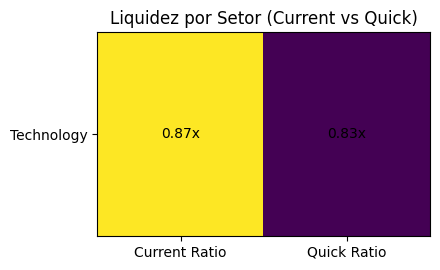